# U-Net: Convolutional Networks for Biomedical Image Segmentation

## Overview

In the following we will implement Unet in pytorch and train on the dataset used by the authors of [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007%2F978-3-319-24574-4_28)

### Libraries

In [55]:
from UNet import Unet
import utils
import engine
from learning_rate_range_test import LRTest

import os
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import gc
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import cv2


## Unet Implementation

The architecture of the model is the following:

![Unet](./imm/unet_arch.png)

It consists of a contracting path (left side) and an expansive path (right side). The constrasting path follows the typical architecture of a convolutional neural network, and it consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.

Let's make sure that the implementation works. We'll check if the output dimensions of the tensors match the ones mentioned in Figure 1 when using the same architecture and same size inputs

In [56]:
x   = torch.Tensor(np.random.rand(2, 3, 572, 572))
ch  = [3, 64, 128, 256, 512, 1024]
net = Unet(channels = ch, no_classes = 4)
x   = net(x)
print(x.shape)

x   = torch.Tensor(np.random.rand(3, 1, 572, 572))
ch  = [1, 64, 128, 256, 512]
net = Unet(channels = ch, no_classes = 2, output_size = (572,572))
x   = net(x)
print(x.shape)

del x, net
gc.collect();

torch.Size([2, 4, 388, 388])
torch.Size([3, 2, 572, 572])


Perfect.

## Training on the 2012 EM Segmentation Challenge 

A test case example of the paper was the [ISBI 2012 challenge](http://brainiac2.mit.edu/isbi_challenge/). This dataset contains 30 ssTEM (serial section Transmission Electron Microscopy) 512x512 images taken from the Drosophila larva ventral nerve cord (VNC). The images represent a set of consecutive slices within one 3D volume. The microcube measures 2 x 2 x 1.5 microns approx., with a resolution of 4x4x50 nm/pixel.

The corresponding binary labels are provided in an in-out fashion, i.e. white for the pixels of segmented objects and black for the rest of pixels (which correspond mostly to membranes).

30 512x512 images of 1 channel can easily fit to memory, so we can load the entire dataset once. 
Let's read the data and visualise an example:

In [57]:
datadir  = './data/images/'
labeldir = './data/labels/'

# Channel and image dimensions (from the data decription)
C, H, W = 1, 512, 512

img_mtrx, mask_mtrx = utils.readData(datadir, labeldir)

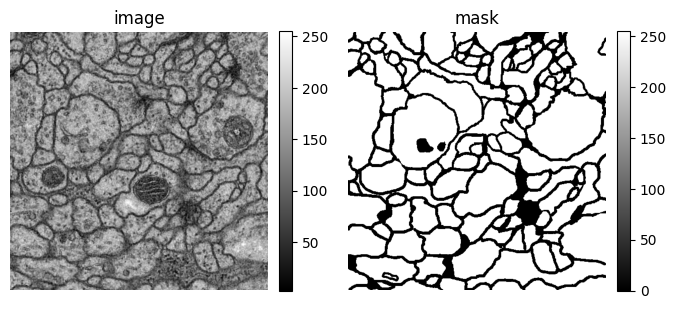

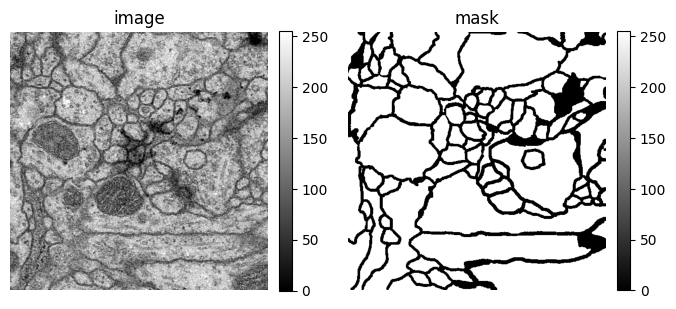

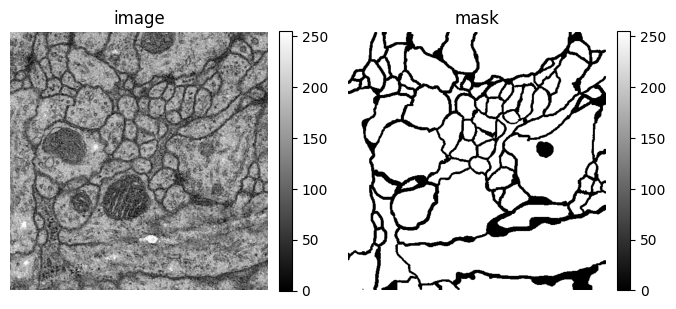

In [58]:
# Plot a few examples
for i in [1, 5, 10]:
    fig, ax = plt.subplots(1, 2, figsize = (8, 8))
    
    im = ax[0].imshow(img_mtrx[i, :, :], 'gray')
    plt.colorbar(im, ax = ax[0], fraction = 0.046, pad = 0.04)
    ax[0].axis('off')
    ax[0].set_title('image')

    im = ax[1].imshow(mask_mtrx[i, :, :], 'gray')
    plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)
    ax[1].axis('off')
    ax[1].set_title('mask')

## Weight map

Authors precompute the weight map for each ground truth segmentation to compensate the different frequency of pixels from a certain class in the training dataset, in order to force the network to learn the small separation borders that they introduce between touching cells.
The separation border is computed using morphological operations, and subsequently the weight map is the computed as:

$w(\mathbf{x}) = w_c(\mathbf{x}) + w_0 \exp \left( - \frac{\left[ d_1(x) + d_2(x)\right]^2}{2\sigma^2} \right) $

where $w_c: \Omega \rightarrow \mathbb{R}$ is the weight map to balance the class fequencies, $d_1:\Omega \rightarrow \mathbb{R}$ is the distance to the border of the nearest cell, and  $d_2:\Omega \rightarrow \mathbb{R}$ is the distance to the border of the second nearest cell.

Let's check a few examples:

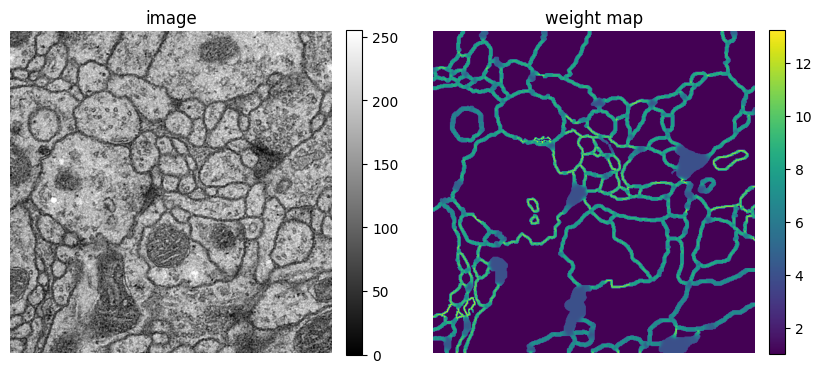

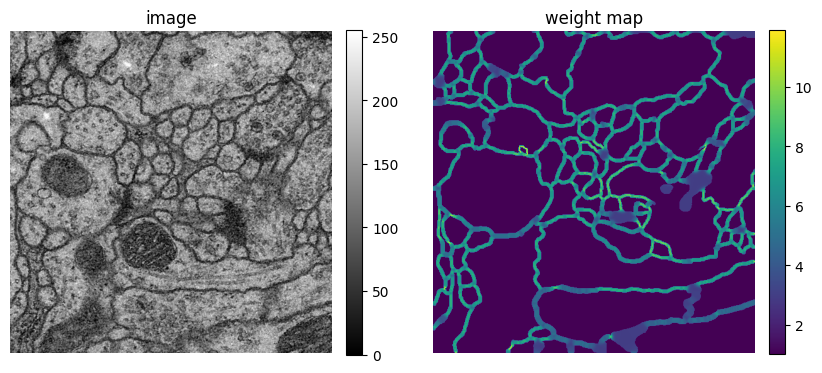

In [59]:
# Parameters used by the authors
w0    = 10
sigma = 5

for i in np.random.randint(0, img_mtrx.shape[0], 2): # Randomly draw 3 images
    
    # Grab image and label map
    mask = mask_mtrx[i, :, :]
    img  = img_mtrx[i, :, :]

    # Compute weight map
    w = utils.weight_map(mask = mask, w0 = w0, sigma = sigma)
    
    # Plot results
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10));

    im = ax[0].imshow(img, 'gray')
    plt.colorbar(im, ax = ax[0], fraction = 0.046, pad = 0.04)
    ax[0].axis('off')
    ax[0].set_title('image')

    im = ax[1].imshow(w)
    plt.colorbar(im, ax = ax[1], fraction = 0.046, pad = 0.04)
    ax[1].axis('off');
    ax[1].set_title('weight map');

Very good

### Data Augmentation

According to the authors we need:
Shift and rotation invariance as well as robustness to deformations and gray value variations. 
Especially random elastic deformations of the training samples were found to be the key concept to train a segmentation network with very few annotated images.

Let's define the transformations:

In [60]:
# Define augmentation pipelines
p = 0.95
train_transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p = p),
        A.VerticalFlip(p = p),
        A.Transpose(p = p),
        A.RandomRotate90(p = p),
        A.ShiftScaleRotate(p = p, shift_limit = 0.0625, scale_limit = 0.1, rotate_limit = 45)
    ], p = 1),
    A.GaussNoise(p = p, var_limit = (0, 20), mean = 0, per_channel = True),
    A.MultiplicativeNoise(p = p, multiplier=(0.9, 1.1), elementwise = True),
    A.ElasticTransform(p = p, alpha = 35, sigma = 5, alpha_affine = 3, approximate = True),
    A.RandomBrightnessContrast(p = p, brightness_limit = 0.15, contrast_limit = 0.15),
    A.PadIfNeeded(p = 1, min_height = 128, min_width = 128, border_mode = cv2.BORDER_REFLECT)
])


Let's have a look:

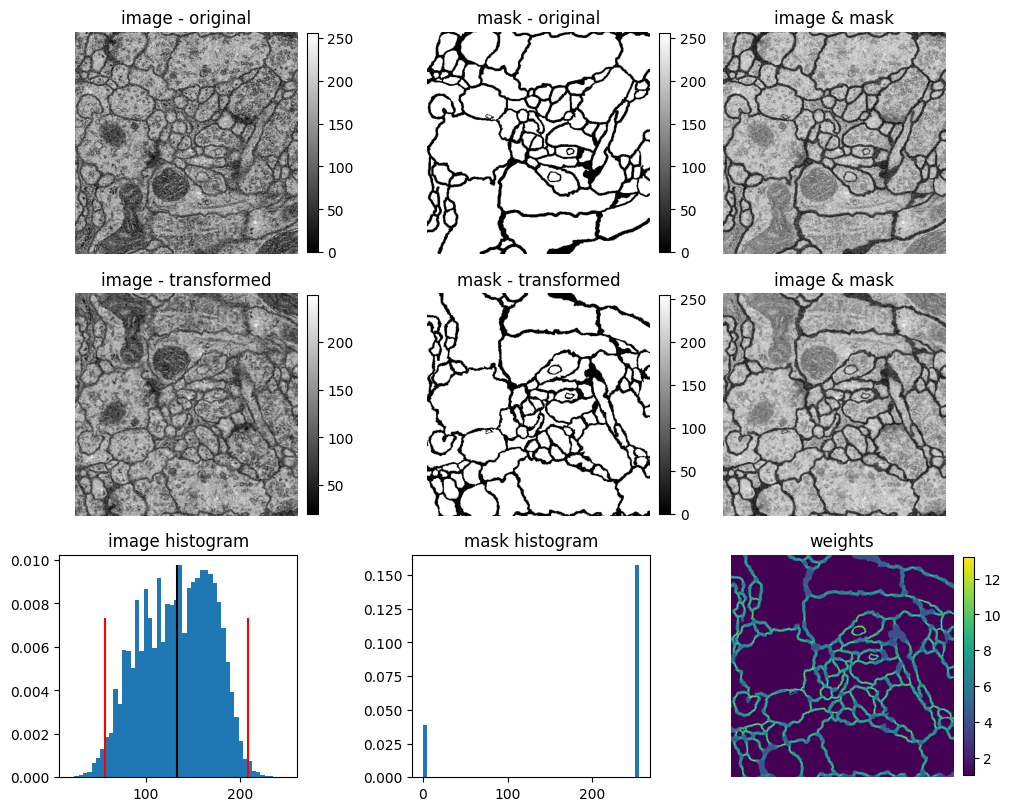

In [68]:
# Parameters recommended by the authors
w0   = 10
sigma = 5

for i in np.random.randint(0, 30, 1): # Randomly draw 1 image
    
    # Grab image and label map
    mask = mask_mtrx[i, :, :]
    img  = img_mtrx[i, :, :]
    
    # Apply transformations
    aug     = train_transform(image = img, mask = mask)
    img_t   = aug["image"]
    mask_t  = aug["mask"]
    
    # Compute weight map
    weights = utils.weight_map(mask = mask_t, w0 = w0, sigma = sigma)

    # Plot
    fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (10,8), constrained_layout=True)
    
    im = ax[0, 0].imshow(img, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[0, 0], fraction = 0.046, pad = 0.04)
    ax[0, 0].axis('off');
    ax[0, 0].set_title('image - original')
    
    im = ax[0, 1].imshow(mask, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[0, 1], fraction = 0.046, pad = 0.04)
    ax[0, 1].axis('off');
    ax[0, 1].set_title('mask - original')
    
    ax[0, 2].imshow(img, 'gray', interpolation = None)
    ax[0, 2].imshow(mask, 'gray', interpolation = None, alpha = 0.3)
    ax[0, 2].axis('off');
    ax[0, 2].set_title('image & mask')
            
    im = ax[1, 0].imshow(img_t, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[1, 0], fraction = 0.046, pad = 0.04)
    ax[1, 0].axis('off');
    ax[1, 0].set_title('image - transformed')
    
    im = ax[1, 1].imshow(mask_t, 'gray', interpolation = None)
    plt.colorbar(im, ax = ax[1, 1], fraction = 0.046, pad = 0.04)
    ax[1, 1].axis('off');
    ax[1, 1].set_title('mask - transformed')
    
    ax[1, 2].imshow(img_t, 'gray', interpolation = None)
    ax[1, 2].imshow(mask_t, 'gray', interpolation = None, alpha = 0.3)
    ax[1, 2].axis('off');
    ax[1, 2].set_title('image & mask')
    
    counts, _, _ = ax[2, 0].hist(img_t.reshape(-1, 1), bins = 50, density = True);
    ax[2, 0].vlines(img_t.mean(), 0, max(counts), colors='k')
    ax[2, 0].vlines(img_t.mean() + 2 * np.std(img_t), 0, max(counts) * 0.75, colors='r')
    ax[2, 0].vlines(img_t.mean() - 2 * np.std(img_t), 0, max(counts) * 0.75, colors='r')
    ax[2, 0].set_title('image histogram')
    
    ax[2, 1].hist(mask_t.reshape(-1, 1), bins = 50, density = True);
    ax[2, 1].set_title('mask histogram')
    
    im = ax[2, 2].imshow(weights, interpolation = None)
    plt.colorbar(im, ax = ax[2, 2], fraction = 0.046, pad = 0.04)
    ax[2, 2].axis('off');
    ax[2, 2].set_title('weights')

Perfect. We can start training

### Learning rate range test

An early stopping class, pixel-wise weighted negative log loss and the training/validation functions have been implemented in the engine module. The authors mention that they used SGD with a batchsize equal to 1 and momentum equal to 0.99. They do not mention the learning rate though.
Let's conduct an [LR test](https://arxiv.org/pdf/1506.01186.pdf) to find a good learning rate.
First, let's make a class for the learning rate range test:

Let's run it:

In [62]:
act_batch_size = 1 # Can't fit more than one image in GPU!
eff_batch_size = 1 # Efective batch (Gradient accumulation)
device        = 'cuda'
momentum      = 0.99
channels      = [C, 64, 128, 256, 512, 1024]
w0            = 10
sigma         = 5

min_lr  = 1e-6
max_lr  = 10
no_iter = 50

# Configure train test split
np.random.seed(123)
no_img    = img_mtrx.shape[0]
test_idx  = np.random.randint(0, no_img, 3) # Keep 3 images for test set
train_idx = np.setdiff1d(np.arange(0, no_img), test_idx)

# Make model
model     = Unet(channels = channels, no_classes = 1).double().to(device)

# Configure criterion
criterion = engine.WeightedBCEWithLogitsLoss(batch_size = act_batch_size)

# Setup optimiser
optimizer = optim.SGD(model.parameters(), lr = min_lr, momentum = momentum)

# Make dataset
train_set = utils.SegmentationDataset(images    = img_mtrx[train_idx, :, :],
                                masks     = mask_mtrx[train_idx, :, :],
                                transform = train_transform,
                                device = device, wmap_w0 = w0, wmap_sigma = sigma)

# Make dataloader
train_loader = DataLoader(dataset = train_set, batch_size = act_batch_size,
                          shuffle = True, num_workers = 0, pin_memory = False)

# Run LR range test
lr_test  = LRTest(min_lr = min_lr, max_lr = max_lr, no_iter = no_iter, batch_size = eff_batch_size)
lr, loss = lr_test(train_loader, criterion, optimizer, model)

AttributeError: module 'utils' has no attribute 'SegmentationDataset'

Let's plot the results:

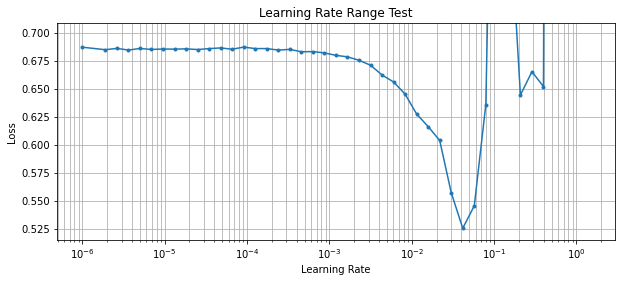

In [ ]:
plt.figure(figsize = (10, 4))
plt.semilogx(lr, loss, marker = '.')
plt.ylim(min(loss) * 0.98, min(loss) * 1.35);
plt.title('Learning Rate Range Test')
plt.ylabel('Loss')
plt.xlabel('Learning Rate')
plt.grid(b = True, which='both', axis='both');

We could go with a learning rate of 1e-2

### Training Loop

Now, we can put everything together. The authors report average performance over 7 rotations of the dataset. We'll just do one here to save time:

In [ ]:
epochs         = 1000
learning_rate  = 1e-2
act_batch_size = 1 # Can't fit more than one image in GPU!
eff_batch_size = 1 # Efective batch (Gradient accumulation)
momentum       = 0.99
device         = 'cuda'
channels       = [C, 64, 128, 256, 512, 1024]
w0             = 10
sigma          = 5
model_path     = './model.pt'

# Early stopping
es = engine.EarlyStopping(patience = 100, fname = model_path)

# Make datasets
train_set = engine.SegmentationDataset(images    = img_mtrx[train_idx, :, :],
                                        masks     = mask_mtrx[train_idx, :, :],
                                        transform = train_transform,
                                        device = device, wmap_w0 = w0, wmap_sigma = sigma)

test_set = engine.SegmentationDataset(images    = img_mtrx[test_idx, :, :],
                                        masks     = mask_mtrx[test_idx, :, :],
                                        transform = None,
                                        device = device, wmap_w0 = w0, wmap_sigma = sigma)

# Make dataloaders
train_loader = DataLoader(dataset     = train_set, 
                          batch_size  = act_batch_size, 
                          shuffle     = True,
                          num_workers = 0,     # Change to >0 for performance
                          pin_memory  = False) # Change to true for performance

test_loader  = DataLoader(dataset     = test_set,  
                          batch_size  = act_batch_size,
                          shuffle     = False, 
                          num_workers = 0,     # Change to >0 for performance
                          pin_memory  = False) # Change to true for performance

# Make progress bars
pbar_epoch = tqdm(total = epochs, unit = 'epoch', position = 0, leave = False)
pbar_train = tqdm(total = len(train_loader), unit = 'batch', position = 1, leave = False)

# Make model
model = Unet(channels = channels, no_classes = 1).double().to(device)

# Make optimiser
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

# Make loss
criterion = engine.WeightedBCEWithLogitsLoss(batch_size = act_batch_size)

# Load checkpoint (if it exists)
cur_epoch = 0
if os.path.isfile(model_path):
    checkpoint   = torch.load(model_path)
    cur_epoch    = checkpoint['epoch']
    es.best_loss = checkpoint['loss']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Hold stats for training process
stats = {'epoch': [], 'train_loss': [], 'val_loss': []}

# Training  / validation loop
for epoch in range(cur_epoch, epochs):
    
    # Train / validate
    pbar_epoch.set_description_str(f'Epoch {epoch + 1}')
    train_loss = engine.train(model, optimizer, train_loader, criterion, eff_batch_size, pbar_train)
    val_loss   = engine.validation(model, test_loader, criterion)
    
    # Append stats
    stats['epoch'].append(epoch)
    stats['train_loss'].append(train_loss)
    stats['val_loss'].append(val_loss)
    
    # Early stopping (just saves model if validation loss decreases when: pass)
    if es(epoch, val_loss, optimizer, model): pass
    
    # Update progress bars
    pbar_epoch.set_postfix(train_loss = train_loss, val_loss = val_loss)
    pbar_epoch.update(1)
    pbar_train.reset()

  0%|          | 0/1000 [00:00<?, ?epoch/s]

  0%|          | 0/27 [00:00<?, ?batch/s]

Let's check the predictions on the validation set:

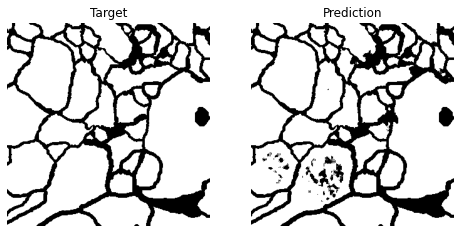

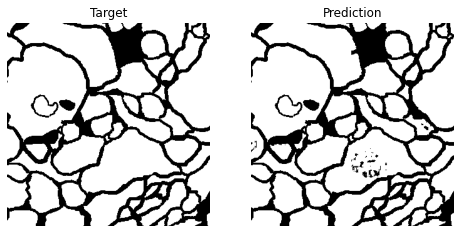

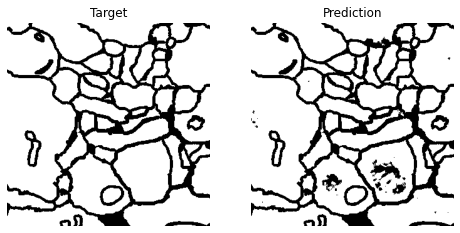

In [ ]:
# load model

model      = Unet(channels = channels, no_classes = 1).double().to(device)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Make loss
criterion = engine.WeightedBCEWithLogitsLoss(batch_size = act_batch_size)
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    
    for batch_id, (X, y, weights) in enumerate(test_loader):

        # Forward
        y_hat = model(X)
        y_hat = torch.sigmoid(y_hat)
        
        
        # Convert to numpy
        X = np.squeeze(X.cpu().numpy())
        y = np.squeeze(y.cpu().numpy())
        w = np.squeeze(weights.cpu().numpy())
        y_hat = np.squeeze(y_hat.detach().cpu().numpy())
        
        # Make mask
        y_hat2 = y_hat > 0.5
    
        # plot
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 8))

        ax[0].imshow(y, 'gray', interpolation = None)
        ax[0].axis('off');
        ax[0].set_title('Target');

        ax[1].imshow(y_hat, 'gray', interpolation = None)
        ax[1].axis('off');
        ax[1].set_title('Prediction');

Not bad, not perfect either.